# Fitting a line to correlated Gaussian data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import oktopus
from oktopus import MultivariateGaussianPosterior, MultivariateGaussianLikelihood, UniformPrior
from oktopus.models import ExpSquaredKernel, WhiteNoiseKernel

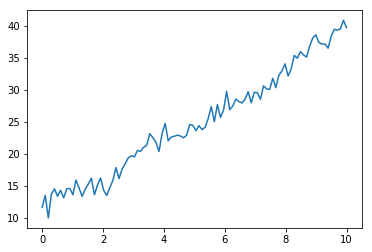

In [2]:
x = np.linspace(0, 10, 100)
def mean(m, b):
    return m * x + b
def cov(k, l, s):
    return ExpSquaredKernel(x).evaluate(k, l) + WhiteNoiseKernel(len(x)).evaluate(s)
fake_data = np.random.multivariate_normal(mean(3, 10), cov(1, 1, 1))
plt.plot(x, fake_data)

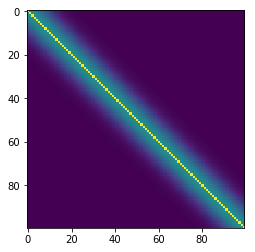

In [3]:
plt.imshow(cov(1, 1, 1))

In [5]:
prior_m = UniformPrior(1, 5, 'm')
prior_b = UniformPrior(4, 15, 'b')
prior_k = UniformPrior(0, 2, 'k')
prior_l = UniformPrior(0, 2, 'l')
prior_s = UniformPrior(0, 2, 's')
prior = prior_m + prior_b + prior_k + prior_l + prior_s
prior.evaluate((2.5, 11, 1.3, 1.5, 0.7))

5.8636311755980977

In [6]:
posterior = MultivariateGaussianPosterior(fake_data, mean, cov, 2, prior)

In [7]:
map_est = posterior.fit(x0=(2.5, 11, 1.3, 1.5, 0.7))
map_est

 final_simplex: (array([[  2.82051004,  10.89814619,   0.97100658,   0.93715254,
          0.96114449],
       [  2.82051947,  10.89805112,   0.97098661,   0.93715591,   0.9611486 ],
       [  2.82050663,  10.89815664,   0.97096361,   0.93714842,
          0.96114204],
       [  2.82051249,  10.8980823 ,   0.97101149,   0.93717506,
          0.96114592],
       [  2.82051276,  10.89808753,   0.9709463 ,   0.93717938,
          0.96115923],
       [  2.82051699,  10.89813066,   0.97095672,   0.93717738,
          0.96114192]]), array([ 122.52756518,  122.52756518,  122.52756518,  122.52756519,
        122.52756519,  122.5275652 ]))
           fun: 122.52756517507162
       message: 'Optimization terminated successfully.'
          nfev: 275
           nit: 164
        status: 0
       success: True
             x: array([  2.82051004,  10.89814619,   0.97100658,   0.93715254,   0.96114449])

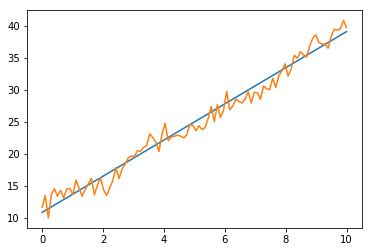

In [8]:
plt.plot(x, mean(*map_est.x[:2]))
plt.plot(x, fake_data)

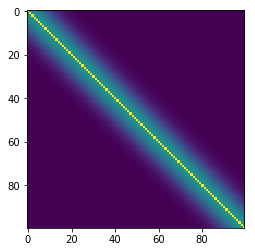

In [9]:
plt.imshow(cov(*map_est.x[2:]))

In [10]:
import emcee
ndim, nwalkers = 5, 100
p0 = [map_est.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lambda params: - posterior.evaluate(params))
sampler.run_mcmc(p0, 5000)

(array([[  2.96304871,  10.2957926 ,   1.5703255 ,   0.87164618,   0.9715209 ],
        [  2.81285673,  10.69682201,   1.04849141,   0.80675458,
           0.95403174],
        [  2.70877098,  11.22507987,   0.96286942,   0.97968502,
           1.00632524],
        [  2.840839  ,  10.5938969 ,   1.72313691,   0.96986166,
           0.97382619],
        [  2.71093936,  11.27080391,   0.94178622,   1.14549959,
           0.93408166],
        [  2.76450953,  11.62680676,   1.33787681,   0.77311134,   0.840111  ],
        [  2.88638081,   9.95636626,   1.11297011,   0.91742809,   0.9638443 ],
        [  2.81818541,  10.56383258,   1.39020835,   0.76289343,
           1.07074439],
        [  2.92479761,  10.11989395,   0.78519238,   1.00023217,
           0.95570968],
        [  2.86461646,  10.8565856 ,   0.96432251,   0.79742223,
           0.94758077],
        [  2.64136683,  11.05470435,   1.25177865,   0.86240549,
           0.88393631],
        [  2.83348278,  10.56513136,   1.571159 

In [12]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
samples.shape

(495000, 5)

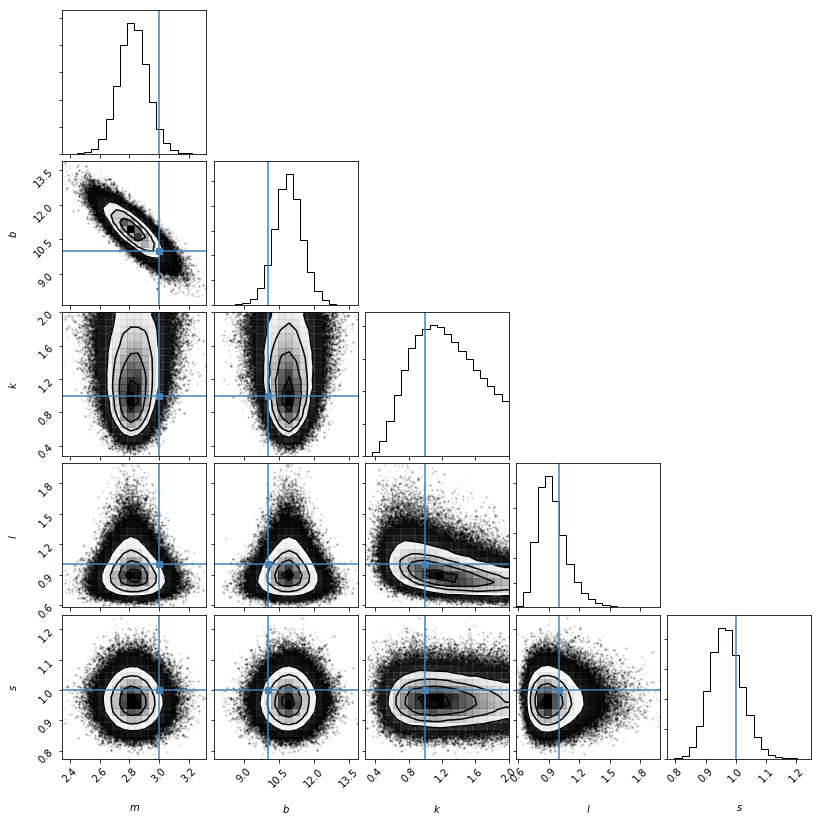

In [13]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$k$", "$l$", "$s$"],
                    truths=[3, 10, 1, 1, 1])

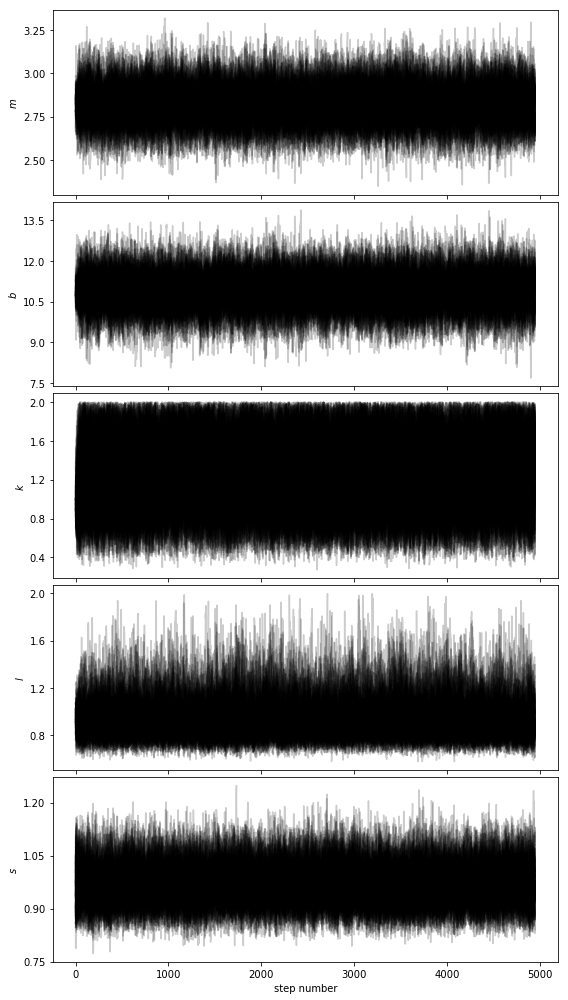

In [14]:
from matplotlib.ticker import MaxNLocator
label = ["$m$", "$b$", "$k$", "$l$", "$s$"]

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 14))
for i in range(0, 5, 1):
    axes[i].plot(sampler.chain[:, 50:, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(label[i])

axes[4].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)